# MP4: Transformer


In this MP, you will learn how to test and train a transformer, which is a sequence-to-sequence neural network in which the relationship between input and output is defined exclusively using dot-product attention.  You will test and train the transformer on some super-simplified natural-language tasks that would be hard to learn using a fully-connected network, though some types of recurrent networks would work as well as a transformer.

If you're reading this webpage online, then the first thing you should do is download the template package:
* [https://courses.engr.illinois.edu/ece448/sp2025/mp4/template.zip](MP4 template package)

## Data

The template includes data, vocabulary, and a pre-trained model for a couple of different natural language tasks.  All of these files are plaintext, so you can read them with a text editor. In order to help you understand their format, though, we have provided a `reader.py` file with some `load` and `save` functions.

### Vocabulary

For example, let's try loading the vocabulary for task 1:

In [1]:
import importlib, reader
help(reader.load_vocabulary)

Help on function load_vocabulary in module reader:

load_vocabulary(vocabularyfile)
    @param:
    vocabularyfile (str) - name of a file that contains a list of unique words
    @return:
    vocabulary (list) - list of those words, in the same order they had in the file



In [2]:
vocabulary = reader.load_vocabulary('data/task1_vocabulary.txt')
print(vocabulary)

['cat', 'swims', 'happily', 'noun', 'verb', 'adverb', 'is', 'in', 'the', 'string', 'of', 'words']


### Dev Data

Task 1 doesn't have any training data, because you will be using dev data to test the provided model.  Try loading the dev data:

In [3]:
help(reader.load_data)

Help on function load_data in module reader:

load_data(datafile, vocabulary)
    Load data from a datafile.
    
    @param:
    datafile (str) - the input filename, one sentence per line
    vocabulary (list) - a list of words in the vocabulary, length V
    
    @return:
    sentences - a list of N sentences, each of which is a list of T words. 
    embeddings - a list of N numpy arrays, each of size T[n]-by-V
      embeddings[n][t,:] is one-hot embedding of the t'th word in the n'th sentence.



In [4]:
importlib.reload(reader)
sentences, embeddings = reader.load_data('data/task1_dev_data.txt', vocabulary)
print('\n'.join([' '.join(sentence) for sentence in sentences]))

the noun in the happily swims cat is cat
the adverb in the string of happily cat swims is happily
in the string happily swims cat the verb is swims
the noun in happily cat swims is cat
the noun in the string of swims happily cat is cat
in the string of words swims cat happily the adverb is happily
the verb in the string of words swims happily cat is swims
the adverb in the string of swims cat happily is happily
the noun in the string of words cat happily swims is cat
in the string of swims happily cat the noun is cat
the noun in the string happily cat swims is cat
the adverb in the string of happily swims cat is happily
the adverb in the string swims cat happily is happily
in swims cat happily the verb is swims
the verb in the string cat happily swims is swims
the adverb in the string of cat swims happily is happily
the verb in the string of happily cat swims is swims
the noun in the string swims cat happily is cat
the adverb in the string of happily swims cat is happily
the adverb in 

As you can see, task 1 is the task of identifying the noun, verb, or adverb in a short three-word sentence.  The target POS (noun, verb, or adverb) is named somewhere in the input. The three-word sentence always contains the words "cat swims happily," but in randomized order.

Let's look at the embeddings for just the first of those sentences.

In [5]:
print(embeddings[0])

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


As you can see, there is one word embedding per row (9 words in `sentences[0]`, 9 rows in `embeddings[0]`). Each word embedding is a one-hot vector, labeling the identity of the corresponding word.  For example, word 0 in the sentence is `the`, which is `vocabulary[8]`, so `embeddings[0,8]==1`. Likewise, word 1 in the sentence is `noun`, which is `vocabulary[3]`, so `embeddings[1,3]==1`.  And so on, down to the last word, `cat`.

### Task Definition

In order to train and test a transformer, we need to know which words are the prompt text (from which we compute key and value vectors), which words are used to generate query vectors, and which words are the outputs (that the transformer tries to generate).

In this MP, we will use a somewhat simple definition.  If a sentence contains $T$ words, we assume that:
* The first $T-2$ words are the prompt text, from which keys and values are generated.
* The last $2$ words are the target output that the transformer should generate.
* In order to generate the second-to-last word of the sentence, the transformer uses a query based on the average of the embeddings of the prompt words.
* In order to generate the last word, the transformer uses a query based on the average of the prompt words and the second-to-last word, i.e., the average of the first $T-1$ words in the sentence.

In [6]:
importlib.reload(reader)
help(reader.define_task)

Help on function define_task in module reader:

define_task(embeddings)
    Split the lexical embeddings into XK, XQ, and Y.
    
    @param:
    embeddings - a T-by-V array, where T is length of the sentence, and V is size of vocabulary
    
    @return:
    XK - a (T-2)-by-V array, with embeddings that are used to generate key and value vectors
    XQ - a 2-by-V array, with embeddings that are used to generate query vectors
    Y - a 2-by-V array, with embeddings that are the output targets for the transformer



In [7]:
XK, XQ, Y = reader.define_task(embeddings[0])
print('XK is:\n',XK)
print('\nXQ is:\n','\n'.join([' '.join(['%.3f'%(x) for x in row]) for row in XQ]))
print('\nY is:\n',Y)

XK is:
 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

XQ is:
 0.143 0.143 0.143 0.143 0.000 0.000 0.000 0.143 0.286 0.000 0.000 0.000
0.125 0.125 0.125 0.125 0.000 0.000 0.125 0.125 0.250 0.000 0.000 0.000

Y is:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


As you can see, `XK` is just the first 7 words of the sentence, and `Y` is just the last two words.  

`XQ` has two rows:
* `XQ[0,:]==` average of the first 7 words of the sentence, including two occurrences of the word `the` (`vocabulary[8]`).
* `XQ[1,:]==`average of the first 8 words of the sentence, including the 7 words of the prompt (`the noun in the happily swims cat`), plus the first word that the transformer is supposed to generate, the word `is` (`vocabulary[6]`).

### Model

For the first task, you will not train a model.  Instead, you will test a model that has been designed by hand to be capable of solving this task.  A one-layer, single-headed transformer model consists of four matrices: $\mathbf{W}_K$, $\mathbf{W}_O$, $\mathbf{W}_Q$, and $\mathbf{W}_V$.  These are used to create the keys, outputs, queries, and value vectors, respectively, according to the equations:

$$\mathbf{K}=\left[\begin{array}{c}\mathbf{k}_1^T\\\vdots\\\mathbf{k}_{T-2}^T\end{array}\right]=\mathbf{X}_K\mathbf{W}_K$$
$$\mathbf{O}=\left[\begin{array}{c}\mathbf{o}_1^T\\\mathbf{o}_2^T\end{array}\right]=\mathbf{C}\mathbf{W}_O$$
$$\mathbf{Q}=\left[\begin{array}{c}\mathbf{q}_1^T\\\mathbf{q}_2^T\end{array}\right]=\mathbf{X}_Q\mathbf{W}_Q$$
$$\mathbf{V}=\left[\begin{array}{c}\mathbf{v}_1^T\\\vdots\\\mathbf{v}_{T-2}^T\end{array}\right]=\mathbf{X}_K\mathbf{W}_V$$



In [8]:
importlib.reload(reader)
help(reader.load_model)

Help on function load_model in module reader:

load_model(modelfile)
    Load a model from a text file.
    
    @param:
    modelfile (str) - name of the file to which model should be saved
    @return:
    WK - numpy array, size V-by-d where V is vocabulary size, d is embedding dimension
    WO - numpy array, size d-by-V where V is vocabulary size, d is embedding dimension
    WQ - numpy array, size V-by-d where V is vocabulary size, d is embedding dimension
    WV - numpy array, size V-by-d where V is vocabulary size, d is embedding dimension



In [9]:
importlib.reload(reader)
WK, WO, WQ, WV = reader.load_model('data/task1_model.txt')
print('WK is\n',WK)
print('WO is\n',WO)
print('WV is\n',WV)

WK is
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
WO is
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
WV is
 [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [

As you can see, for this simple model, $\mathbf{W}_K$ and $\mathbf{W}_V$ are identity matrices, meaining that the key and value vectors are exactly equal to the input word embeddings.  

$\mathbf{W}_O$ is almost an identity matrix, except that it maps from the input word `in` (index 7) to the output word `is` (index 6).  Thus, if it finds that the context vector is the word `in`, then the output should be the word `is`.

The matrix that is significantly non-trivial is $\mathbf{W}_Q$, which is set up so that: 
* If the prompt contains `noun` but not `is`, then it generates a query vector that gives greatest weight to the word `in` (`WQ[3,7]==2.5` is the largest entry in its row).
* If the prompt+generated first word contains the sequence `noun... is`, then it generates a query vector that gives greatest weight to the word `cat` (`WQ[3,0]+WQ[6,0]==3`, which is the largest entry in the sum of these two rows).
* If the prompt contains `adverb` but not `is`, then it generates a query vector that gives greatest weight to the word `in` (`WQ[4,7]==2.5` is the largest entry in its row).
* If the prompt+generated first word contains the sequence `adverb... is`, then it generates a query vector that gives greatest weight to the word `happily` (`WQ[4,1]+WQ[6,1]==3`, which is the largest entry in the sum of these two rows).
* If the prompt contains `verb` but not `is`, then it generates a query vector that gives greatest weight to the word `in` (`WQ[5,6]==2.5` is the largest entry in its row).
* If the prompt+generated first word contains the sequence `verb... is`, then it generates a query vector that gives greatest weight to the word `swims` (`WQ[5,2]+WQ[6,2]==3`, which is the largest entry in the sum of these two rows).


In [10]:
print('WQ is\n',WQ)

WQ is
 [[-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [  2.  -99.  -99.  -99.  -99.  -99.  -99.    2.5 -99.  -99.  -99.  -99. ]
 [-99.    2.  -99.  -99.  -99.  -99.  -99.    2.5 -99.  -99.  -99.  -99. ]
 [-99.  -99.    2.  -99.  -99.  -99.  -99.    2.5 -99.  -99.  -99.  -99. ]
 [  1.    1.    1.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]
 [-99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99.  -99. ]]


## Task 1: Test an existing transformer

For task 1, you will test the existing transformer model that we just loaded.  In order to do that, you'll need to modify three functions in `transformer.py`:  `softmax,` `forward,` and `generate`.

### softmax



The softmax of a row vector $\mathbf{v}^T$ is a vector of the same dimensions as $\mathbf{v}^T$ whose $j^{\text{th}}$ element is:
$$\text{softmax}_j(\mathbf{v})=\frac{\exp(v_j)}{\sum_k \exp(v_k)}$$
For example, if the vector is $\mathbf{v}=[0,1,0,0]^T$, then its softmax is
$$\text{softmax}([0,1,0,0]^T)=\left[\frac{1}{3+e},\frac{e}{3+e},\frac{1}{3+e},\frac{1}{3+e}\right]^T$$

In [11]:
import numpy as np
import transformer
v = np.array([0,1,0,0])
print(np.exp(v)/sum(np.exp(v)))

[0.1748777  0.47536689 0.1748777  0.1748777 ]


Write the function `transformer.softmax` so it computes the result shown above.

In [12]:
importlib.reload(transformer)
transformer.softmax([0,1,0,0])

array([[0.1748777 , 0.47536689, 0.1748777 , 0.1748777 ]])

That's all there is to it, except... Except that the `np.exp` function can quickly lead to numerical overflow if its input is even moderately large.  For example, consider the vector $\mathbf{v}=[990,991,990,990]^T$.  Its softmax is
$$\text{softmax}([990,991,990,990]^T)=\left[
\frac{e^{990}}{e^{990}+e^{991}+e^{990}+e^{990}},
\frac{e^{991}}{e^{990}+e^{991}+e^{990}+e^{990}},\ldots\right]^T$$
$$=\left[
\frac{e^{990}}{e^{990}}\times\left(\frac{1}{3+e}\right),
\frac{e^{990}}{e^{990}}\times\left(\frac{e}{3+e}\right),\ldots\right]^T$$
$$=\left[\frac{1}{3+e},\frac{e}{3+e},\frac{1}{3+e},\frac{1}{3+e}\right]^T$$

When we try to compute it, though, we get the following error:

In [13]:
v = [990,991,990,990]
print(np.exp(v)/np.sum(np.exp(v)))

[nan nan nan nan]


C:\Users\27364\AppData\Local\Temp\ipykernel_2124\3156646497.py:2: RuntimeWarning: overflow encountered in exp
  print(np.exp(v)/np.sum(np.exp(v)))
C:\Users\27364\AppData\Local\Temp\ipykernel_2124\3156646497.py:2: RuntimeWarning: invalid value encountered in divide
  print(np.exp(v)/np.sum(np.exp(v)))


We have encountered the following problem: $e^{990}$ is too large to be computed.

A good solution is to subtract the maximum element from $\mathbf{v}$ before computing the softmax.  That way, the largest element in the sum is always $e^0=1$, which is easy to represent on any computer.

In [14]:
numerator = np.exp(v - np.amax(v))
print('The numerator of the softmax is\n',numerator)
prob = numerator / np.sum(numerator)
print('\nand the softmax output is\n',prob)

The numerator of the softmax is
 [0.36787944 1.         0.36787944 0.36787944]

and the softmax output is
 [0.1748777  0.47536689 0.1748777  0.1748777 ]


Revise your code in `transformer.softmax` so that it works well even with very large logit vectors.

In [15]:
importlib.reload(transformer)
print(transformer.softmax([990,991,990,990]))

[[0.1748777  0.47536689 0.1748777  0.1748777 ]]


Finally, in order to compute attention, we will find it very useful to compute the softmax normalization on every row of a matrix.  Revise your code in `transformer.softmax` so that it performs the normalization separately on every row of an input matrix.

In [16]:
importlib.reload(transformer)
print(transformer.softmax([[990,991,990,990],[0,0,1,0]]))

[[0.1748777  0.47536689 0.1748777  0.1748777 ]
 [0.1748777  0.1748777  0.47536689 0.1748777 ]]


### forward

Now we are ready to implement the forward pass of a transformer.

In [17]:
help(transformer.forward)

Help on function forward in module transformer:

forward(XK, XQ, WK, WO, WQ, WV)
    Perform one layer of transformer inference, using trained model, on given data.
    
    @param:
    XK - (T-2)-by-V array containing embeddings of words to be used for keys and values
    XQ - 2-by-V array containing embeddings of words to be used for queries
    WK - V-by-d array mapping X to K
    WO - d-by-V array mapping C to O
    WQ - V-by-d array mapping X to Q
    WV - V-by-d array mapping X to V
    
    @return:
    A - 2-by-(T-2) array, A[i,j] is attention the i'th query pays to the j'th key
    C - 2-by-d array, context vectors from which P is computed
    K - (T-2)-by-d array, key vectors computed from XK
    O - 2-by-V array, O[i,j] is probability that i'th output word should be j
    Q - 2-by-d array, query vectors computed from XQ
    V - (T-2)-by-d array, value vectors computed from XK



After computing the matrices $\mathbf{K}$, $\mathbf{Q}$, and $\mathbf{V}$, you need to compute the attention matrix $\mathbf{A}$, the context matrix $\mathbf{C}$, the output logist $\mathbf{O}$, and the output probabilities $\mathbf{P}$ according to:

$$\mathbf{A}=\text{softmax}(\mathbf{Q}\mathbf{K}^T)$$
$$\mathbf{C}=\mathbf{A}\mathbf{V}$$
$$\mathbf{O}=\text{softmax}(\mathbf{C}\mathbf{W}_O)$$


If you try this using the task1 model and the first sentence of the task1 data, you should find that:
* $\mathbf{K}$ and $\mathbf{V}$ are equal to the prompt embedding $\mathbf{X}_K$


In [18]:
importlib.reload(transformer)
A, C, K, O, Q, V = transformer.forward(XK, XQ, WK, WO, WQ, WV)
print('K is\n',K)
print('V is\n',V)

K is
 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
V is
 [[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


You should also find that:

* $\mathbf{Q}$ is a two-row matrix whose maximum elements are the vocabulary indices of the word `in` in the first row (element 7), and the word `cat` in the second row (element 0)


In [19]:
print('Q is\n','\n'.join([' '.join(['%.2f'%(q) for q in row]) for row in Q]))

Q is
 -84.57 -99.00 -99.00 -99.00 -99.00 -99.00 -99.00 -84.50 -99.00 -99.00 -99.00 -99.00
-73.88 -86.50 -86.50 -99.00 -99.00 -99.00 -99.00 -86.31 -99.00 -99.00 -99.00 -99.00


* $\mathbf{A}$ is a two-row matrix whose maximum elements are pointers to the positions, in the input sentence, of the words `in` in the first row (element 2), and of the word `cat` in the second row (element 6)


In [20]:
print('A is\n','\n'.join([' '.join(['%.2f'%(q) for q in row]) for row in A]))

A is
 0.00 0.00 0.52 0.00 0.00 0.00 0.48
0.00 0.00 0.00 0.00 0.00 0.00 1.00


* $\mathbf{C}$ is a two-row matrix whose maximum elements are the same as those of $\mathbf{Q}$


In [21]:
print('C is\n','\n'.join([' '.join(['%.2f'%(q) for q in row]) for row in C]))

C is
 0.48 0.00 0.00 0.00 0.00 0.00 0.00 0.52 0.00 0.00 0.00 0.00
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00


* $\mathbf{O}$ is a two-row matrix.  Each of its rows is a probability vector (non-negative, sums to one).  Maximum elements are the vocabulary indices of the word `is` in the first row (element 6) and the word `cat` in the second row (element 0)

In [22]:
print('O is\n','\n'.join([' '.join(['%.2f'%(q) for q in row]) for row in O]))

O is
 0.12 0.08 0.08 0.08 0.08 0.08 0.13 0.08 0.08 0.08 0.08 0.08
0.20 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07 0.07


## generate

In [23]:
importlib.reload(transformer)
help(transformer.generate)

Help on function generate in module transformer:

generate(embeddings, vocabulary, WK, WO, WQ, WV)
    Perform inference on the provided embeddings, and report the generated sentences.
    
    @param:
    embeddings - a list of one-hot embedding matrices, one per sentence
    vocabulary - a list of words in the vocabulary
    WK - V-by-d array mapping X to K
    WO - d-by-V array mapping C to O
    WQ - V-by-d array mapping X to Q
    WV - V-by-d array mapping X to V
    
    @return:
    generated - a list of generated sentences, each as a list of space-separated words.
      The first T-2 words of each sentence should be vocabulary items indexed by the
      argmax of the first T-2 embeddings.  The last 2 words of each sentence should be
      vocabulary items indexed by the argmax of the two outputs computed by running
      the transformer with the provided WK, WO, WQ, and WV.



The `generate` function should do the following things for each sentence:
* Use `reader.define_task` to generate XK, XQ, and Y
* Look up the vocabulary items corresponding to the argmax in each row of XK
* Use `forward` to generate transformer outputs
* Look up the vocabulary items corresponding to the argmax in each row of O

If your code is working, it should be able to generate correct answers for all of the sentences in task1:


In [24]:
importlib.reload(transformer)
generated = transformer.generate(embeddings,vocabulary,WK,WO,WQ,WV)
for ref,hyp in zip(sentences,generated):
    print('Hypothesis:',' '.join(hyp))
    print('\tReference:',' '.join(ref),' --- ',sum([x!=y for x,y in zip(ref,hyp)]),'errors')

Hypothesis: the noun in the happily swims cat is cat
	Reference: the noun in the happily swims cat is cat  ---  0 errors
Hypothesis: the adverb in the string of happily cat swims is happily
	Reference: the adverb in the string of happily cat swims is happily  ---  0 errors
Hypothesis: in the string happily swims cat the verb is swims
	Reference: in the string happily swims cat the verb is swims  ---  0 errors
Hypothesis: the noun in happily cat swims is cat
	Reference: the noun in happily cat swims is cat  ---  0 errors
Hypothesis: the noun in the string of swims happily cat is cat
	Reference: the noun in the string of swims happily cat is cat  ---  0 errors
Hypothesis: in the string of words swims cat happily the adverb is happily
	Reference: in the string of words swims cat happily the adverb is happily  ---  0 errors
Hypothesis: the verb in the string of words swims happily cat is swims
	Reference: the verb in the string of words swims happily cat is swims  ---  0 errors
Hypothesis:

Just to make sure that your code is actually calculating outputs, try running it with completely random weight matrices.  You should get 2 errors in almost every sentence.

In [25]:
importlib.reload(transformer)
V = len(vocabulary)
generated = transformer.generate(
    embeddings,
    vocabulary,
    np.random.uniform(0,1,(V,V)),
    np.random.uniform(0,1,(V,V)),
    np.random.uniform(0,1,(V,V)),
    np.random.uniform(0,1,(V,V))
)
for ref,hyp in zip(sentences,generated):
    print('Hypothesis:',' '.join(hyp))
    print('\tReference:',' '.join(ref),' --- ',sum([x!=y for x,y in zip(ref,hyp)]),'errors')


Hypothesis: the noun in the happily swims cat happily happily
	Reference: the noun in the happily swims cat is cat  ---  2 errors
Hypothesis: the adverb in the string of happily cat swims happily happily
	Reference: the adverb in the string of happily cat swims is happily  ---  1 errors
Hypothesis: in the string happily swims cat the verb happily happily
	Reference: in the string happily swims cat the verb is swims  ---  2 errors
Hypothesis: the noun in happily cat swims happily happily
	Reference: the noun in happily cat swims is cat  ---  2 errors
Hypothesis: the noun in the string of swims happily cat happily happily
	Reference: the noun in the string of swims happily cat is cat  ---  2 errors
Hypothesis: in the string of words swims cat happily the adverb happily happily
	Reference: in the string of words swims cat happily the adverb is happily  ---  1 errors
Hypothesis: the verb in the string of words swims happily cat happily happily
	Reference: the verb in the string of words sw

## Task 2: Train a Transformer

For task 2, you are not provided with a transformer.  However, you do have 100 sentences of training data!  The data are similar to those of task 1, but with a greater variety of nouns, verbs, and adverbs:

In [26]:
importlib.reload(reader)
vocabulary = reader.load_vocabulary('data/task2_vocabulary.txt')
sentences, embeddings = reader.load_data('data/task2_train_data.txt', vocabulary)
print('\n'.join([' '.join(s) for s in sentences]))

the noun in the string of happily cat programs is cat
the adverb in the string happily dog swims is happily
the verb in happily cat programs is programs
in the string of words programs capybara strongly the adverb is strongly
the noun in quickly programs dog is dog
in the capybara paints strongly the verb is paints
in the string strongly capybara programs the verb is programs
in the strongly swims cat the noun is cat
the noun in the string of words quickly capybara swims is capybara
the verb in the swims quickly capybara is swims
the verb in happily swims cat is swims
the noun in the string of words strongly cat programs is cat
the adverb in swims dog quickly is quickly
the noun in the string of words programs happily dog is dog
the adverb in the string cat swims strongly is strongly
in capybara strongly programs the adverb is strongly
in the string of quickly capybara swims the adverb is quickly
the adverb in the dog paints happily is happily
the noun in programs capybara quickly is c

In order to perform training, you'll need to write three methods: `cross_entropy_loss`, `gradient`, and `train`.


### Cross Entropy Loss


First, write a function called `loss` that calculates the loss and the derivative of the loss.  Given a transformer output $\mathbf{O}$ whose elements are $o_{i,j}\in[0,1]$ and a corresponding set of one-hot target vectors $\mathbf{Y}$ whose elements are $y_{i,j}\in\{0,1\}$, the cross-entropy loss is

$$\mathcal{L}=-\sum_i y_{i,j}\ln \max\left(o_{i,j},\epsilon\right)$$

where $\epsilon$ is the python constant `sys.float_info.min`, and is used here just to make sure we don't get floating-point underflow. 

The derivatives of cross-entropy with respect to $o_{i,j}$ and $\mathbf{O}$ are
$$
\frac{\partial\mathcal{L}}{\partial o_{i,j}}=-\frac{y_{i,j}}{o_{i,j}},~~~
\frac{\partial\mathcal{L}}{\partial\mathbf{O}}=-\frac{\mathbf{Y}}{\mathbf{O}},
$$
where the division is an element-wise or "array" division (https://numpy.org/doc/2.2/reference/generated/numpy.divide.html). 

In [27]:
importlib.reload(transformer)
help(transformer.cross_entropy_loss)

Help on function cross_entropy_loss in module transformer:

cross_entropy_loss(O, Y)
    Calculate losses from network outputs O if target one-hot vectors are Y.
    
    @param:
    O - NQ-by-V array.  O[n,v]=probability that n'th output is v.
    Y - NQ-by-V array. Y[n,v]=1 if n'th target is v, else Y[n,v]=0.
    
    @return:
    L - cross-entropy loss, summed over all rows
    dO - NQ-by-V array.  Derivatives of the loss with respect to the elements of O.



For example, suppose we look up $\mathbf{Y}$ for the first train embedding, randomly generate a (correctly-normalized) probability matrix of the same size, then find the resulting loss and loss gradient:

In [28]:
XK, XQ, Y = reader.define_task(embeddings[0])
print('Y is\n',Y)

O = np.random.uniform(0, 100, size=Y.shape)
O /= np.expand_dims(np.sum(O,axis=1), axis=1)
print('O is')
print('\n'.join([' '.join(['%.2g'%(o) for o in row]) for row in O]))

Y is
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
O is
0.0043 0.044 0.084 0.059 0.023 0.089 0.084 0.067 0.054 0.082 0.038 0.062 0.084 0.058 0.09 0.055 0.011 0.012
0.0036 0.0033 0.041 0.044 0.019 0.062 0.042 0.13 0.061 0.053 0.017 0.072 0.073 0.097 0.1 0.095 0.0059 0.079


In [29]:
importlib.reload(transformer)
L, dO = transformer.cross_entropy_loss(O,Y)
print('Total loss is',L, 'which should equal', -np.log(O[0,12])-np.log(O[1,0]))
print('Its derivative dL/dO is')
print('\n'.join([' '.join(['%.2g'%(o) for o in row]) for row in dO]))

Total loss is 8.092925557234285 which should equal 8.092925557234285
Its derivative dL/dO is
-0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -12 -0 -0 -0 -0 -0
-2.8e+02 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0 -0


### Gradient

Now that we know the loss (and its derivative with respect to $O$), we need to find the derivative of the loss with respect to all of the model parameters: $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_K}$, $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_O}$, $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_Q}$, and $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_V}$.

In order to calculate those derivatives, you will want to use the chain rule.  In order to do that, you might find it useful to think about the two types of layer that are used repeatedly in the transformer: matrix multiplication, and the softmax function.

#### Matrix Multiplication

Suppose you have three matrices, $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{C}$, whose elements are $a_{i,j}$, $b_{j,k}$, and $c_{i,k}$, and suppose that

$$\mathbf{C}=\mathbf{A}\mathbf{B} ~~~\Leftrightarrow~~~ c_{i,k}=\sum_j a_{i,j}b_{j,k}$$

Suppose you know $\frac{\partial\mathcal{L}}{\partial\mathbf{C}}$, whose elements are $\frac{\partial\mathcal{L}}{\partial c_{i,k}}$.  Then

$$\frac{\partial\mathcal{L}}{\partial a_{i,j}}=\sum_k\frac{\partial\mathcal{L}}{\partial c_{i,k}}b_{j,k}~~~\Leftrightarrow~~~ \frac{\partial\mathcal{L}}{\partial\mathbf{A}}=\frac{\partial\mathcal{L}}{\partial\mathbf{C}}\mathbf{B}^T$$

$$\frac{\partial\mathcal{L}}{\partial b_{j,k}}=\sum_i a_{i,j}\frac{\partial\mathcal{L}}{\partial c_{i,k}}~~~\Leftrightarrow~~~ \frac{\partial\mathcal{L}}{\partial\mathbf{B}}=\mathbf{A}^T\frac{\partial\mathcal{L}}{\partial\mathbf{C}}$$


#### Softmax

Suppose you have two matrices, $\mathbf{A}$ and $\mathbf{Z}$, whose elements are $a_{i,j}$ and $z_{i,j}$, and suppose that

$$\mathbf{A}=\text{softmax}\left(\mathbf{Z}\right) ~~~\Leftrightarrow~~~ a_{i,j}=\frac{e^{z_{i,j}}}{\sum_\ell e^{z_{i,\ell}}}$$

Suppose you know $\frac{\partial\mathcal{L}}{\partial\mathbf{A}}$, whose elements are $\frac{\partial\mathcal{L}}{\partial a_{i,j}}$.  Then

$$\frac{\partial\mathcal{L}}{\partial z_{m,n}}=\sum_k\frac{\partial\mathcal{L}}{\partial a_{m,k}}\frac{\partial a_{m,k}}{\partial z_{m,n}}=a_{m,n}\left(\frac{\partial\mathcal{L}}{\partial a_{m,n}}-\sum_k a_{m,k}\frac{\partial\mathcal{L}}{\partial a_{m,k}}\right)$$


The idea of the `gradient` function is to apply the above formulas, one by one backward through the transformer, until you are able to calculate the desired derivatives $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_K}$, $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_O}$, $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_Q}$, and $\frac{\partial\mathcal{L}}{\partial\mathbf{W}_V}$:

In [30]:
importlib.reload(transformer)
help(transformer.gradient)

Help on function gradient in module transformer:

gradient(XK, XQ, Y, WK, WO, WQ, WV, A, C, K, O, Q, V)
    Compute gradient of cross-entropy loss with respect to WK, WO, WQ, and WV
    given the input data in K, Q, and V, and the target outputs in Y.
    
    @param:
    XK - one embedding per row, first n-2 words in the sentence
    XQ - one embedding per row, 3rd-from-last and 2nd-from-last words in the sentence
    Y - one embedding per row, last two words in the sentence
    O - 2-by-V array, O[i,j] is probability that i'th output word should be j
    C - 2-by-d array, context vectors from which O is computed
    V - (T-2)-by-d array, value vectors of which each row of C is a weighted average
    A - 2-by-(T-2) array, A[i,j] is attention the i'th query pays to the j'th key
    K - (T-2)-by-d array, key vectors computed from XK
    Q - 2-by-d array, query vectors computed from XQ
    
    @return:
    dWK - gradient of cross-entropy with respect to WK
    dWO - gradient of cross-en

Without writing the `train` function, the only way to test your `gradient` function is by calculating the desired values (e.g., by hand, or using some other code), and then comparing them to the values your code produces.  In order to help you out, we've provided some examples of desired values in the function `test/test_visible.py,` which you can access using python's unittest facility:

In [31]:
import unittest
unittest.TextTestRunner(buffer=False).run(unittest.defaultTestLoader.discover('tests'))

................
----------------------------------------------------------------------
Ran 16 tests in 0.007s

OK


<unittest.runner.TextTestResult run=16 errors=0 failures=0>

### Train the transformer

The `train` function should use stochastic gradient descent to train the transformer.

In [32]:
importlib.reload(transformer)
help(transformer.train)

Help on function train in module transformer:

train(embeddings, WK, WO, WQ, WV, learningrate, num_iters)
    Train a transformer using stochastic gradient descent (SGD).
    Each iteration of SGD should choose one training sentence, uniformly at random,
    compute the loss and loss gradient for that one sentence,
    then adjust the parameters WK, WO, WQ and WV in the direction of the negative
    gradient scaled by the learningrate.
    
    @param:
    embeddings - embeddings[i][j,:] is one-hot vector of the j'th word in the i'th training sentence
    WK - the matrix that multiplies each embedding to produce a key
    WO - the matrix that multiplies the context vector to produce an output logit vector
    WQ - the matrix that multiplies each embedding to produce a query
    WV - the matrix that multiplies each embedding to produce a value
    learningrate - scalar learning rate
    num_iters - number of iterations of SGD to perform
    
    @return:
    losses - losses[t]=cross-ent

The parameters can be initialized randomly, e.g., using np.random.normal with a small standard deviation.

In [33]:
V = len(vocabulary)
WK0 = np.random.normal(loc=0,scale=0.001,size=(V,V))
WO0 = np.random.normal(loc=0,scale=0.001,size=(V,V))
WQ0 = np.random.normal(loc=0,scale=0.001,size=(V,V))
WV0 = np.random.normal(loc=0,scale=0.001,size=(V,V))

importlib.reload(transformer)
losses, WK, WO, WQ, WV = transformer.train(embeddings,WK0,WO0,WQ0,WV0,0.01,50000)

Text(0.5, 1.0, 'Training losses, transformer MP task 2')

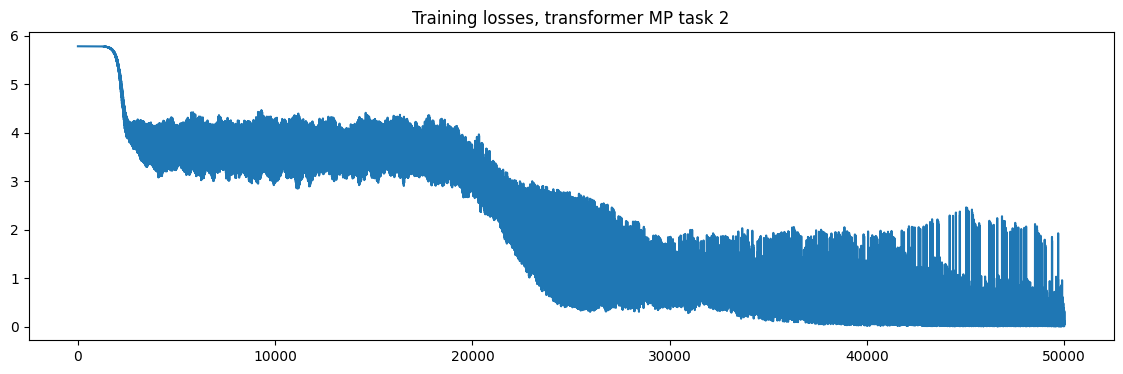

In [34]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,4))
ax = fig.subplots(1)
ax.plot(losses)
ax.set_title('Training losses, transformer MP task 2')

Training a transformer is kind of hard.  For this task, there tend to be three quite distinct training periods:
* In the first training period, the transformer is assigning roughly equal probability to all words in the vocabulary, so the average loss is around $-2\log(1/V)\approx 6$.
* In the second training period, the transformer has learned to produce the word `is` at the end of each sentence, but has not yet learned to produce the correct noun, verb, or adverb.  During this period the average loss is around $-\log(1/V)\approx 3$.
* In the third training period, the transformer learns how to usually produce the correct noun, verb, or adverb.  At this point the average training loss drops to 0 on good iterations, with bad iterations that have much larger loss. Over time, the frequency of bad iterations continues to drop.

If you don't see a training curve with all three periods, try adjusting your learning rate or num_iters until you get a curve with this behavior. 


In [35]:
dev, devX = reader.load_data('data/task2_dev_data.txt', vocabulary)
generated = transformer.generate(devX,vocabulary,WK,WO,WQ,WV)
for ref,hyp in zip(dev,generated):
    print('Hypothesis:',' '.join(hyp))
    print('\tReference:',' '.join(ref),' --- ',sum([x!=y for x,y in zip(ref,hyp)]),'errors')


Hypothesis: the noun in the happily swims cat is cat
	Reference: the noun in the happily swims cat is cat  ---  0 errors
Hypothesis: the verb in the string paints cat strongly is paints
	Reference: the verb in the string paints cat strongly is paints  ---  0 errors
Hypothesis: the verb in the string quickly programs capybara is swims
	Reference: the verb in the string quickly programs capybara is programs  ---  1 errors
Hypothesis: the adverb in the string of words capybara programs strongly is strongly
	Reference: the adverb in the string of words capybara programs strongly is strongly  ---  0 errors
Hypothesis: the adverb in the string swims quickly capybara is quickly
	Reference: the adverb in the string swims quickly capybara is quickly  ---  0 errors
Hypothesis: the adverb in the swims happily capybara is happily
	Reference: the adverb in the swims happily capybara is happily  ---  0 errors
Hypothesis: the noun in the string capybara strongly programs is dog
	Reference: the noun i

## Grading your work

To grade your code, upload `transformer.py` to gradescope.  The autograder will run three types of tests:

* `test_visible.py` is exactly the same as the code available to you in the template
* `test_hidden.py` runs the same tests, but with different parameter values
* `test_training.py` runs `transformer.train` for 50,000 iterations on a task that is similar to task 2, but with different vocabulary

